## Steps to Implement Faster RCNN
1. Import requires libraries and load data
2. Data Preprocessing
3. Defining model architecture
4. Testing the model

## Import Required Libraries and Load the Dataset

In [ ]:
# import required libraries
import os
import numpy as np
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as pc

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
## mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip the data
!unzip '/content/drive/MyDrive/train_zedkk38-200624-203536.zip'

## Data Preprocessing

In [ ]:
# reading csv file
data = pd.read_csv('train.csv')
data.head()

,image_names,cell_type,xmin,xmax,ymin,ymax
0,1.jpg,RBC,68,165,154,249
1,1.jpg,RBC,1,66,145,260
2,1.jpg,RBC,207,334,160,270
3,1.jpg,RBC,435,540,347,437
4,1.jpg,RBC,535,639,356,464


In [ ]:
# preprocessing data
data['cell_type'] = data['cell_type'].replace({'RBC': 1, 'WBC': 2, 'Platelets': 3})
data = data.loc[(data['cell_type'] == 1) | (data['cell_type'] == 2)]

data = data.loc[(data['xmax'] > data['xmin'] + 20) | (data['ymax'] > data['ymin'] + 20)]

In [ ]:
# defining required transformations
from torchvision import transforms as TF

transform = TF.Compose([
    TF.Resize((224, 224)),
    TF.ToTensor()
])

In [ ]:
## convert list of list to tuple
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# defining class to load data
class BloodCellDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files
        self.imgs = data.image_names.unique()

    def __getitem__(self, idx):
        # load images
        img_name = self.imgs[idx]
        img_path = os.path.join(self.root, img_name)
        img = Image.open(img_path)

        num_objs = data[data['image_names'] == img_name].shape[0]
        boxes = []
        cell_type = []
        for i in range(num_objs):
            xmin = data[data['image_names'] == img_name]['xmin'].iloc[i]
            xmax = data[data['image_names'] == img_name]['xmax'].iloc[i]
            ymin = data[data['image_names'] == img_name]['ymin'].iloc[i]
            ymax = data[data['image_names'] == img_name]['ymax'].iloc[i]
            target = data[data['image_names'] == img_name]['cell_type'].iloc[i]
            boxes.append([xmin, ymin, xmax, ymax])
            cell_type.append(target)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(cell_type, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        if self.transforms is not None:
            img = self.transforms(img)
            boxes[:, 0] = boxes[:, 0] * (224/640)
            boxes[:, 2] = boxes[:, 2] * (224/640)
            boxes[:, 1] = boxes[:, 1] * (224/480)
            boxes[:, 3] = boxes[:, 3] * (224/480)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = BloodCellDataset('/content/images/', transforms=transform)

In [ ]:
# defining data loader
data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=8, 
    shuffle=False, 
    collate_fn=collate_fn
)

In [ ]:
# testing for one iteration
for batch_x, batch_y in data_loader:
    break

In [ ]:
batch_x[0].shape

torch.Size([3, 224, 224])

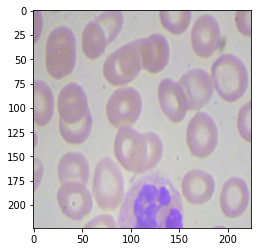

In [ ]:
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))

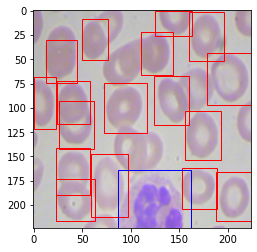

num RBCs tensor(17)
num WBCs tensor(1)


In [ ]:
# plot bounding box
plt.axes()
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))
for i in range(len(batch_y[0]['boxes'])):
    bbox = batch_y[0]['boxes'][i]
    x1, y1 = bbox[0], bbox[1]
    x2, y2 = bbox[2], bbox[3]

    if batch_y[0]['labels'][i] == 1:
        color = 'red'
    elif batch_y[0]['labels'][i] == 2:
        color = 'blue'

    rectangle = pc.Rectangle((x1,y1), x2-x1, y2-y1, fc='none',ec=color)
    plt.gca().add_patch(rectangle)
plt.show()
print('num RBCs', (batch_y[0]['labels'] == 1).sum())
print('num WBCs', (batch_y[0]['labels'] == 2).sum())

## Defining the model

In [ ]:
# define model
model = fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
num_classes = 3

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# check model on one image
model.eval()
output = model(batch_x[1].view(1, 3, 224, 224))

In [ ]:
output

[{'boxes': tensor([[1.0523e+02, 1.5971e+02, 1.4485e+02, 2.0228e+02],
          [0.0000e+00, 7.1911e+01, 8.9467e+01, 2.1121e+02],
          [0.0000e+00, 1.4223e+02, 5.9156e+01, 2.2147e+02],
          [0.0000e+00, 3.1597e+01, 2.9490e+01, 7.7126e+01],
          [1.0048e+02, 1.9035e+02, 1.3679e+02, 2.2220e+02],
          [1.6699e+02, 2.0110e+02, 1.9040e+02, 2.2381e+02],
          [2.9442e+01, 1.9404e+02, 1.0896e+02, 2.2400e+02],
          [9.2009e+01, 1.7519e+02, 1.3212e+02, 2.1882e+02],
          [1.6060e+02, 7.1178e+00, 2.0196e+02, 4.8032e+01],
          [1.5660e+02, 4.9451e+01, 1.8984e+02, 1.0015e+02],
          [1.3645e+02, 9.4590e+01, 1.6336e+02, 1.5179e+02],
          [0.0000e+00, 4.0014e+01, 1.6575e+02, 2.2400e+02],
          [2.0744e+00, 9.2879e+01, 4.5440e+01, 2.2400e+02],
          [9.0180e+01, 1.1287e+02, 1.5116e+02, 2.1947e+02],
          [2.8198e+01, 1.8062e+02, 7.5751e+01, 2.2171e+02],
          [1.1891e+02, 1.6971e+02, 1.3726e+02, 1.9455e+02],
          [1.1684e+02, 0.0000e+

In [ ]:
# transfer model to GPU
model = model.to("cuda")

In [ ]:
# define optimization 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# set model to train
model.train()

# train model
for epoch in range(2):

    # initialize variables
    epoch_classif_loss = epoch_regress_loss = cnt = 0

    # loop through the data
    for batch_x, batch_y in data_loader:
        # get batch images and targets and transfer them to GPU
        batch_x = list(image.to("cuda") for image in batch_x)
        batch_y = [{k: v.to("cuda") for k, v in t.items()} for t in batch_y]

        # clear gradients
        optimizer.zero_grad()

        # pass images to model and get loss
        loss_dict = model(batch_x, batch_y)
        losses = sum(loss for loss in loss_dict.values())

        # do a backward pass
        losses.backward()

        # update gradients
        optimizer.step()

        # sum loss and get count
        epoch_classif_loss += loss_dict['loss_classifier'].item()
        epoch_regress_loss += loss_dict['loss_box_reg'].item()
        cnt += 1

    # take average loss for all batches
    epoch_classif_loss /= cnt
    epoch_regress_loss /= cnt
    
    # print loss
    print("Training loss for epoch {} is {} for classification and {} for regression "
        .format(epoch + 1, epoch_classif_loss, epoch_regress_loss)
    )

Training loss for epoch 1 is 0.32951349252834916 for classification and 0.5070651145651937 for regression 
Training loss for epoch 2 is 0.1969883614219725 for classification and 0.303532472345978 for regression 


## Model Evaluation

In [ ]:
# selecting one image from dataset
image = Image.open('images/1.jpg')
image = transform(image)

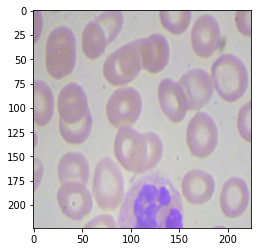

In [ ]:
plt.imshow(np.transpose(image, (1, 2, 0)))

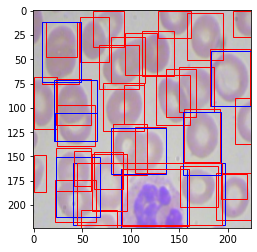

num RBCs tensor(37)
num WBCs tensor(9)


In [ ]:
# check model on one image
model.eval()
output = model(image.unsqueeze(dim=0).cuda())
output = [{k: v.to("cpu") for k, v in t.items()} for t in output]

# plot bounding box
plt.axes()
plt.imshow(np.transpose(image, (1, 2, 0)))
for i in range(len(output[0]['boxes'])):
    bbox = output[0]['boxes'][i]
    x1, y1 = bbox[0], bbox[1]
    x2, y2 = bbox[2], bbox[3]

    if output[0]['labels'][i] == 1:
        color = 'red'
    elif output[0]['labels'][i] == 2:
        color = 'blue'
    else:
        color = 'green'
    x1 = x1.detach().numpy()
    y1 = y1.detach().numpy()
    x2 = x2.detach().numpy()
    y2 = y2.detach().numpy()
    rectangle = pc.Rectangle((x1,y1), x2-x1, y2-y1, fc='none',ec=color)
    plt.gca().add_patch(rectangle)
plt.show()
print('num RBCs', (output[0]['labels'] == 1).sum())
print('num WBCs', (output[0]['labels'] == 2).sum())